## Here we try to detect the language of the reviews, using Machine Learning
### Combining 2 datasets of Hotels and Reviews

In [89]:
import warnings
warnings.filterwarnings("ignore")#Ignoring warnings to clean up the notebook
import json
import os
import pandas as pd
from dateutil import parser
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#Mention the path with the .json files
data_path = 'Data/'

In [53]:
key_list_hotel=['name', 'location', 'price', 'room_type', 'link', 'review_score', 'review_category', 'no_of_reviews', 
                'amenities', 'ratings', 'reviews_list']

key_list_ratings_hotel=['Best Rating', 'Staff', 'Facilities', 'Cleanliness', 'Comfort', 'Value for money', 'Location', 
                       'Free WiFi']

data_hotel = pd.DataFrame(columns=['Hotel_Name', 'City', 'Distance_for_Center', 'Chepest_Room_Price_$', 'Cheapest_Room_Type', 
                            'Average_Hotel_Rating', 'Review_category', 'No_of_Reviews', 'ammenities', 'Best_Rating', 
                            'Staff_Rating', 'Facilities_Rating', 'Cleanliness_Rating', 'Confort_Rating', 
                            'Value_for_Money_Rating', 'Location_rating', 'Free_Wifi_Rating'])


data_reviews = pd.DataFrame(columns=['Hotel_Name', 'Reviewer_Name', 'Reviewer_Country', 'Room_Type', 'Review_Month', 'Review_Year',
                                    'Stay_Period_Nights', 'Stay_Start_Date', 'Reviewer_Group_Type', 'Main_Review', 
                                    'Review_Rating', 'Review_Likes', 'Review_Dislikes'])

In [54]:
#Loading Hotel Data
for i in os.listdir(data_path):
    if '.json' in i:
        f=open(data_path+i)
        tmp=json.load(f)
        for city in tmp:
            city=tmp['city_name']
            for hotel in tmp['hotel_list']: 
                for key in key_list_hotel:
                    if key not in hotel.keys():
                        hotel['key']=None

                    for sub_key in key_list_ratings_hotel:
                        if sub_key not in hotel['ratings'].keys():
                            hotel['ratings'][sub_key] = None

                data_hotel=data_hotel.append({'Hotel_Name':hotel['name'],
                          'City': city,
                          'Distance_for_Center':hotel['location'],
                          'Chepest_Room_Price_$':hotel['price'],
                          'Cheapest_Room_Type':hotel['room_type'], 
                          'Average_Hotel_Rating':hotel['review_score'],
                          'Review_category':hotel['review_category'],
                          'No_of_Reviews':hotel['no_of_reviews'],
                          'ammenities':hotel['amenities'],
                          'Best_Rating':hotel['ratings']['Best Rating'],
                          'Staff_Rating':hotel['ratings']['Staff'],
                          'Facilities_Rating':hotel['ratings']['Facilities'],
                          'Cleanliness_Rating':hotel['ratings']['Cleanliness'],
                          'Confort_Rating':hotel['ratings']['Comfort'], 
                          'Value_for_Money_Rating':hotel['ratings']['Value for money'],
                          'Location_rating':hotel['ratings']['Location'], 
                          'Free_Wifi_Rating':hotel['ratings']['Free WiFi']}, ignore_index=True)

del tmp, key, sub_key, f, i, city, hotel, key_list_hotel, key_list_ratings_hotel

data_hotel['Distance_for_Center']= data_hotel['Distance_for_Center'].str.split(' ').str[0].astype(float)
data_hotel['No_of_Reviews']= data_hotel['No_of_Reviews'].str.split(' ').str[0].str.replace('\,','').astype(int)
data_hotel['Chepest_Room_Price_$']= data_hotel['Chepest_Room_Price_$'].str.strip('$').str.replace(',','').astype(float)
data_hotel['City']=data_hotel['City'].apply(lambda x: 'San Francisco' if len(x)==4 else x)
data_hotel['City']=data_hotel['City'].apply(lambda x: 'San Diego' if 'San Diego' in x else x)
data_hotel['City']=data_hotel['City'].apply(lambda x: 'Los Angeles' if 'Los Angeles' in x else x)

In [56]:
#Due to limited RAM, loading only 50 reviews per hotel
for i in tqdm.tqdm(os.listdir(data_path)):
    if '.json' in i:
        f=open(data_path+i)
        tmp=json.load(f)
        for city in tmp:
            city=tmp['city_name']
            for hotel in tmp['hotel_list']: 
                for review in hotel['reviews_list'][:50]:
                    data_reviews=data_reviews.append({
                        'City':city,
                        'Hotel_Name':hotel, 
                        'Reviewer_Name':review['Reviewer_Name'], 
                        'Reviewer_Country':review['Reviewer_Country'], 
                        'Room_Type':review['Room_Type'], 
                        'Review_Month':review['Review_Month'].split(' ')[0],
                        'Review_Year':review['Review_Month'].split(' ')[1],
                        'Stay_Period_Nights':review['Stay_Period'], 
                        'Stay_Start_Date':parser.parse(review['Stay_Start_Date']), 
                        'Reviewer_Group_Type':review['Reviewer_Group_Type'], 
                        'Main_Review':review['Main_Review'], 
                        'Review_Rating':review['Review_Rating'], 
                        'Review_Likes':review['Review_Likes'], 
                        'Review_Dislikes':review['Review_Dislikes']
                    }, ignore_index=True)
                
del f, tmp, city, hotel, review
data_reviews['City']=data_reviews['City'].apply(lambda x: 'San Francisco' if len(x)==4 else x)
data_reviews['City']=data_reviews['City'].apply(lambda x: 'San Diego' if 'San Diego' in x else x)
data_reviews['City']=data_reviews['City'].apply(lambda x: 'Los Angeles' if 'Los Angeles' in x else x)

100%|███████████████████████████████████████████| 15/15 [04:16<00:00, 17.13s/it]


In [57]:
#Getting rid of incorrect values
data_reviews=data_reviews[data_reviews['Stay_Period_Nights']!='Couple'].reset_index(drop=True)
data_reviews=data_reviews[~data_reviews['Stay_Period_Nights'].str.contains('Solo')].reset_index(drop=True)
data_reviews=data_reviews[data_reviews['Stay_Period_Nights']!='Family'].reset_index(drop=True)
data_reviews=data_reviews[data_reviews['Stay_Period_Nights']!='Group'].reset_index(drop=True)

In [58]:
data_reviews['Stay_Period_Nights']=data_reviews['Stay_Period_Nights'].str.split(' ').str[0].astype(int)

In [59]:
print(data_hotel.shape)
print(data_reviews.shape)

(1856, 17)
(61864, 14)


In [60]:
#Population 'None' and 'N/A' with '' No Character
data_reviews['Main_Review']=data_reviews['Main_Review'].fillna('').str.replace('N/A','')
data_reviews['Review_Likes']=data_reviews['Review_Likes'].fillna('').str.replace('N/A','')
data_reviews['Review_Dislikes']=data_reviews['Review_Dislikes'].fillna('').str.replace('N/A','')

In [61]:
data_reviews.head()

,Hotel_Name,Reviewer_Name,Reviewer_Country,Room_Type,Review_Month,Review_Year,Stay_Period_Nights,Stay_Start_Date,Reviewer_Group_Type,Main_Review,Review_Rating,Review_Likes,Review_Dislikes,City
0,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Edmonton,Canada,King/Double Room,November,2022,5,2022-11-18,Family,Exceptional,10,Location was great. Very clean hotel,Price,San Francisco
1,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Evan,United States,King Room with City View,March,2023,3,2023-03-10,Couple,"Great hotel in a great location, good value",9.0,"Great city view, the staff was very accommodat...",,San Francisco
2,{'name': 'Hyatt Centric Fisherman's Wharf San ...,John,Australia,Standard King Room,February,2023,4,2023-02-22,Couple,"Comfort, cleanliness, welcoming vibe, friendly...",9.0,Extremely pleasant experience from a late book...,,San Francisco
3,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Sandra,United States,Double Room with Two Double Beds and City View,February,2023,1,2023-02-22,Family,It was great,8.0,I booked rooms with city view but did not get ...,,San Francisco
4,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Nathan,United States,Standard Double Room with Two Double Beds,February,2023,1,2023-02-21,Solo traveller,The beauty if the bed,8.0,closer to everythings,the hotel hide it,San Francisco


## Combining Main Review, likes and Dislikes to detect the language

In [62]:
#Combining Main Review, likes and Dislikes to detect the language
#Adding space and Full Stop to combine
data_reviews['Combined_Review']=data_reviews['Main_Review']+pd.Series([' .']*data_reviews.shape[0]) \
+data_reviews['Review_Likes'] + pd.Series([' .']*data_reviews.shape[0]) +data_reviews['Review_Dislikes']

In [63]:
#Getting the hotel city from the hotel dataset to the reviews dataset and only keeping the necessary columns
data_reviews=data_reviews[['City','Hotel_Name','Reviewer_Country', 'Combined_Review', 'Stay_Period_Nights', 'Reviewer_Name']]

In [64]:
data_reviews.head()

,City,Hotel_Name,Reviewer_Country,Combined_Review,Stay_Period_Nights,Reviewer_Name
0,San Francisco,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Canada,Exceptional .Location was great. Very clean ho...,5,Edmonton
1,San Francisco,{'name': 'Hyatt Centric Fisherman's Wharf San ...,United States,"Great hotel in a great location, good value .G...",3,Evan
2,San Francisco,{'name': 'Hyatt Centric Fisherman's Wharf San ...,Australia,"Comfort, cleanliness, welcoming vibe, friendly...",4,John
3,San Francisco,{'name': 'Hyatt Centric Fisherman's Wharf San ...,United States,It was great .I booked rooms with city view bu...,1,Sandra
4,San Francisco,{'name': 'Hyatt Centric Fisherman's Wharf San ...,United States,The beauty if the bed .closer to everythings ....,1,Nathan


In [65]:
#We will detect the language using the lang detect library
# Install the library
#!pip install langdetect
from langdetect import detect, detect_langs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=edc08d9e45ee6fdf2b68ac55fe03650bec85bb4d668a8d74320169e8bf9f360a
  Stored in directory: /Users/suvivarshney/Library/Caches/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [75]:
def language_detection(text, method = "single"):
    try:
        if(method.lower() != "single"):
            result = detect_langs(text)
        else:
            result = detect(text)
        return result
    #If there is no text (No review)
    except:
        return 'en'

In [76]:
data_reviews['Language']=data_reviews['Combined_Review'].apply(lambda x: language_detection(x))

In [80]:
#Count of Languages
data_reviews['Language'].value_counts()

en       58875
es         582
fr         437
nl         415
de         348
af         193
ro         146
pt         123
ru         100
it          82
so          75
ja          56
da          54
ca          47
ko          42
tl          35
he          34
cy          31
pl          29
hu          23
tr          22
sv          15
id          14
no          13
zh-cn       13
hr           9
et           7
sl           7
ar           6
fi           6
sw           5
el           4
cs           4
zh-tw        3
lv           2
mk           2
vi           2
sk           2
sq           1
Name: Language, dtype: int64

In [81]:
#Percentage of Languages
data_reviews['Language'].value_counts(normalize=True)

en       0.951684
es       0.009408
fr       0.007064
nl       0.006708
de       0.005625
af       0.003120
ro       0.002360
pt       0.001988
ru       0.001616
it       0.001325
so       0.001212
ja       0.000905
da       0.000873
ca       0.000760
ko       0.000679
tl       0.000566
he       0.000550
cy       0.000501
pl       0.000469
hu       0.000372
tr       0.000356
sv       0.000242
id       0.000226
no       0.000210
zh-cn    0.000210
hr       0.000145
et       0.000113
sl       0.000113
ar       0.000097
fi       0.000097
sw       0.000081
el       0.000065
cs       0.000065
zh-tw    0.000048
lv       0.000032
mk       0.000032
vi       0.000032
sk       0.000032
sq       0.000016
Name: Language, dtype: float64

In [87]:
data_reviews['Language'].value_counts().values

array([58875,   582,   437,   415,   348,   193,   146,   123,   100,
          82,    75,    56,    54,    47,    42,    35,    34,    31,
          29,    23,    22,    15,    14,    13,    13,     9,     7,
           7,     6,     6,     5,     4,     4,     3,     2,     2,
           2,     2,     1])

## As we can see, the top language by a good majority is English. Lets see what languages, other than english are dominant

Text(0.5, 1.0, 'Normalized Language Percentages')

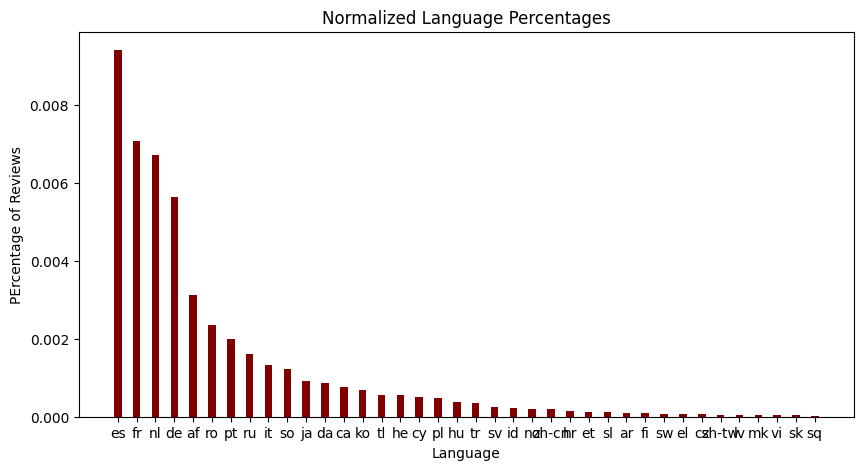

In [94]:
#Top Languages other than English
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data_reviews['Language'].value_counts(normalize=True).index[1:], data_reviews['Language'].value_counts(normalize=True).values[1:], color ='maroon',
        width = 0.4)
 
plt.xlabel("Language")
plt.ylabel("PErcentage of Reviews")
plt.title("Normalized Language Percentages")

In [108]:
#Top 5 languages spoken by guests in each city
group=data_reviews.groupby(['City','Language'])['Language'].value_counts()
group.groupby(level=[0]).nlargest(5)

City           City           Language  Language
Los Angeles    Los Angeles    en        en          17520
                              es        es            341
                              de        de            186
                              nl        nl            183
                              fr        fr            179
Sacramento     Sacramento     en        en           1579
                              nl        nl             30
                              fr        fr             13
                              af        af              9
                              de        de              9
San Diego      San Diego      en        en          21209
                              fr        fr             88
                              nl        nl             82
                              es        es             80
                              af        af             70
San Francisco  San Francisco  en        en          18567
                       